In [1]:
import pandas as pd
import numpy as np

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_dataframe(filename):
    df = pd.read_csv(filename)
    
    # Handle missing values
    df = df.dropna(subset=['price'])
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    df['last_review'] = pd.to_datetime(df['last_review'])
    
    # Apply a log10 transformation to the target column
    df['price'] = np.log10(df['price'])

    return df

In [3]:
def preprocess(df):
    # Calculate IQR
    Q1 = df['price'].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df['price'].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].reset_index(drop=True)
    
    return df


In [4]:
df_train = read_dataframe("../datasets/airbnb-listings-may.csv")
df_val = read_dataframe("../datasets/airbnb-listings-june.csv")

In [5]:
df_train = preprocess(df_train)
df_val = preprocess(df_val)

In [6]:
len(df_train), len(df_val)

(328, 357)

In [7]:
df_train.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,1489424,"Welcoming, easygoing, comfy bed, entire level",5294164,Efrat,NaN,FOURTEENTH WARD,42.66719,-73.81580,Private room,1.698970,1,250,2024-04-21,1.93,1,255,48,NaN
1,3820211,Restored Precinct in Center Sq. w/Parking,19648678,Terra,NaN,SIXTH WARD,42.65222,-73.76724,Entire home/apt,2.071882,2,300,2024-04-28,2.53,4,361,15,NaN
2,5651579,Large studio apt by Capital Center & ESP@,29288920,Gregg,NaN,SECOND WARD,42.64615,-73.75966,Entire home/apt,1.954243,1,343,2024-04-21,3.13,2,15,28,NaN
3,6623339,Center Sq. Loft in Converted Precinct w/ Parking,19648678,Terra,NaN,SIXTH WARD,42.65222,-73.76724,Entire home/apt,2.079181,2,314,2024-04-27,2.89,4,357,11,NaN
4,8035784,Delightful French Victorian,42430824,John M,NaN,TENTH WARD,42.66063,-73.78115,Private room,2.298853,3,18,2020-07-25,0.17,2,179,0,NaN


In [15]:
# Feature selection
numerical = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
categorical = ['room_type', 'neighbourhood']
    
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
val_dicts[1]

{'room_type': 'Entire home/apt',
 'neighbourhood': 'SIXTH WARD',
 'latitude': 42.65222,
 'longitude': -73.76724,
 'minimum_nights': 2,
 'number_of_reviews': 302,
 'reviews_per_month': 2.53,
 'availability_365': 253}

In [17]:
target = "price"

y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
y_train[0]

1.6989700043360187

### LinearRegression

In [20]:
# Create a pipeline with DictVectorizer and LinearRegression
pipeline = Pipeline([
    ('dv', DictVectorizer()),           # Converts dictionaries into feature matrices
    ('lr', LinearRegression())         # Linear regression model
])

pipeline.fit(train_dicts, y_train)
y_pred = pipeline.predict(val_dicts)
rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE: ", rmse)

RMSE:  0.16307290098131869


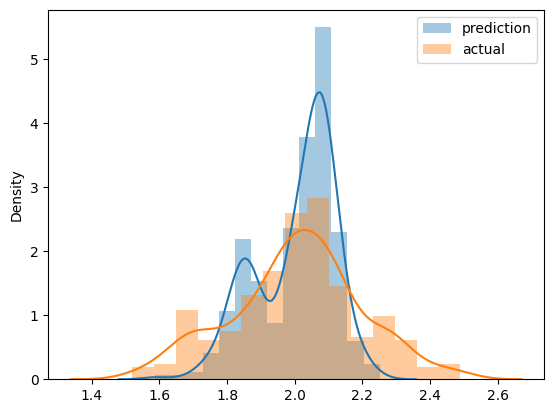

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()
plt.show()

In [14]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)

### Lasso

In [21]:
# Create a pipeline with DictVectorizer and LinearRegression
pipeline = Pipeline([
    ('dv', DictVectorizer()),           # Converts dictionaries into feature matrices
    ('lr', Lasso(0.01))         # Linear regression model
])

pipeline.fit(train_dicts, y_train)
y_pred = pipeline.predict(val_dicts)
rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE: ", rmse)

RMSE:  0.16806515990534673


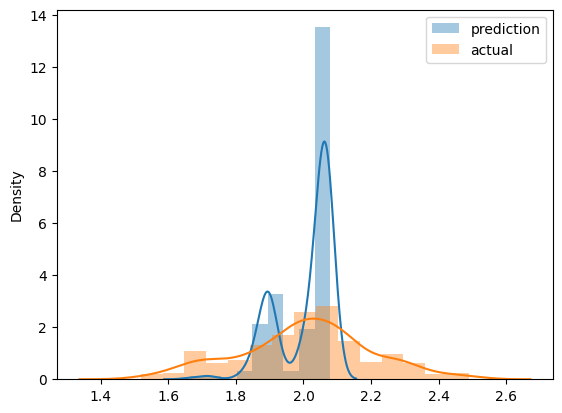

In [22]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()
plt.show()